In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, exposure, color
from skimage.transform import resize
import pandas as pd
import glob
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.utils import class_weight
import tensorflow as tf
import re
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.python.keras.layers import Dense, Dropout, Flatten
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
# mount drive on Google drive to access training data
# Ignore this if you don't use Google Colab
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Access training data in My Drive
train_path = "/content/drive/My Drive/ECE_542/TrainData-C2/"
# get training labels
train_labels = pd.read_csv("/content/drive/My Drive/ECE_542/TrainData-C2/TrainAnnotations.csv")
train_labels.sort_values(by=["file_name"], inplace=True)
train_files = glob.glob(train_path + "*.jpg")
train_files.sort()

In [0]:
#sanity check
train_labels.annotation[100]
print(train_labels.file_name[100])
print(train_files[100])
re.sub(train_path, "", train_files[100])

002191.jpg
/content/drive/My Drive/ECE_542/TrainData-C2/002191.jpg


'002191.jpg'

# Helper functions

In [0]:
def extract_data(file_names, labels, size=None):
  """
  Extract all images given list of file names and list of labels.  Also resize
  images according to user-defined size
  Inputs:
  - filenames: list of file paths to images
  - labels: list of label of each image; order based on the order of filenames
  Outputs:
  - images: list of RGB images
  - annotations: list of labels for the images
  """
  images = []
  annotations = []
  for idx, f in enumerate(file_names):
    img = io.imread(f)
    if size is not None:
      img = resize(img, (size, size), anti_aliasing=True)
    images.append(img)
    annotations.append(labels[idx])
  return images, annotations

In [0]:
def RGB2HSV(images, hue=False):
  """
  Convert all RGB images into HSV channel
  Input:
  - images: list of images of shape (H, W, 3)
  """
  hsv = []
  for img in images:
    if hue:
      hsv.append(color.rgb2hsv(img)[:,:,0])
    else:
      hsv.append(color.rgb2hsv(img))
  return hsv

# Load and pre-process image

__Pre-processing steps__

1. Extract data
2. (Optional) convert images to HSV channels
3. Put images in a dataframe for easier access of classes' samples
4. Divide training-validation set.  Validation set consist of 50 images from each class
5. Perform image augmentation on training data



In [0]:
# This cell may take awhile to run
# extract all data
images, labels = extract_data(train_files, train_labels.annotation, 224)

# convert images to HSV (uncomment if needed)
images = RGB2HSV(images)

# convert images to hue (uncomment if needed)
#images = RGB2HSV(images, hue=True)

# Preparing training and data model

In [0]:
# Split training and validation test set
Y = to_categorical(labels)
X = np.array(images)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=32)

# prepare data for oversampling and undersampling
# UNCOMMENT IF TRAINING IN RGB OR HSV
n_train, H, W, C = X_train.shape  # dimension of training data

# UNCOMMENT IF TRAINING IN HUE
#n_train, H, W = X_train.shape  # dimension of training data in hue space

n_val = len(X_val)  # number of samples in validation set

# UNCOMMENT IF TRAINING IN RGB OR HSV
X_train = np.reshape(X_train, (n_train, H*W*C))
X_val = np.reshape(X_val, (n_val, H*W*C))

# UNCOMMENT IF TRAINING IN HUE
#X_train = np.reshape(X_train, (n_train, H*W))
#X_val = np.reshape(X_val, (n_val, H*W))

# oversampling the train set
oversample = SMOTE(random_state=32)
X_train, Y_train = oversample.fit_resample(X_train, Y_train)

# undersampling the validation set
cc = ClusterCentroids(random_state=32)
X_val, Y_val = cc.fit_resample(X_val, Y_val)

# reshape training and validation data to prepare for training
# UNCOMMENT IF TRAINING IN RGB OR HSV
X_val = np.reshape(X_val, (len(X_val), H, W, C))
X_train = np.reshape(X_train, (len(X_train), H, W, C))

# UNCOMMENT IF TRAINING IN HUE
#X_val = np.reshape(X_val, (len(X_val), H, W, 1))
#X_train = np.reshape(X_train, (len(X_train), H, W, 1))

# Checking the shape of training and validation data
print(X_val.shape)
print(X_train.shape)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

(190, 224, 224, 3)
(1675, 224, 224, 3)


In [0]:
# Construct CNN with 4 convolutional layers
cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))  # the last one would be 1 when train with hue
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(Dense(512, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(128, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))

cnn4.add(Dense(5, activation='softmax'))

In [0]:
# Compile the model
sgd = SGD(lr=0.01, momentum=0.9)
cnn4.compile(loss="categorical_crossentropy",
              optimizer=sgd,
              metrics=['accuracy'])

In [0]:
cnn4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 220, 220, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 64)      1

In [0]:
# Traing model without ImageDataGenerator
history4 = cnn4.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=15,
                    validation_data=(X_val, Y_val))

Epoch 1/15
53/53 [==============================] - 98s 2s/step - loss: 1.6808 - accuracy: 0.4334 - val_loss: 14.5624 - val_accuracy: 0.2000
Epoch 2/15
53/53 [==============================] - 96s 2s/step - loss: 0.7308 - accuracy: 0.7278 - val_loss: 5.2517 - val_accuracy: 0.2263
Epoch 3/15
53/53 [==============================] - 97s 2s/step - loss: 0.4838 - accuracy: 0.8233 - val_loss: 3.9042 - val_accuracy: 0.2632
Epoch 4/15
53/53 [==============================] - 100s 2s/step - loss: 0.3522 - accuracy: 0.8693 - val_loss: 2.3447 - val_accuracy: 0.3211
Epoch 5/15
53/53 [==============================] - 100s 2s/step - loss: 0.2427 - accuracy: 0.9152 - val_loss: 1.3310 - val_accuracy: 0.5526
Epoch 6/15
53/53 [==============================] - 98s 2s/step - loss: 0.2145 - accuracy: 0.9224 - val_loss: 1.0027 - val_accuracy: 0.6684
Epoch 7/15
53/53 [==============================] - 97s 2s/step - loss: 0.1668 - accuracy: 0.9504 - val_loss: 1.1447 - val_accuracy: 0.6632
Epoch 8/15
53/53 

<Figure size 432x288 with 0 Axes>

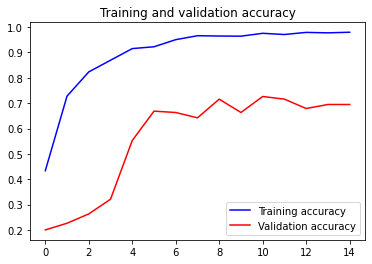

<Figure size 432x288 with 0 Axes>

In [0]:
# plot learning curves
accuracy = history4.history['accuracy']
val_accuracy = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

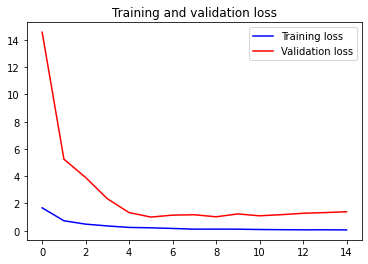

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

# Making prediction on the test set

In [0]:
# Loading the test set
# Access testing data in My Drive
test_path = "/content/drive/My Drive/ECE_542/TestData/"
test_files = glob.glob(test_path + "*.jpg")
test_files.sort()

In [0]:
# Load all testing data and convert them into hsv 
test_data = []
for f in test_files:
  img = io.imread(f)
  # rescale images to half original size
  img = resize(img, (240, 240), anti_aliasing=True)
  #hsv = color.rgb2hsv(img)
  #hue = color.rgb2hsv(img)[:,:,0]
  test_data.append(img)

In [0]:
# making prediction
predict = cnn4.predict_classes(np.array(test_data))
print(predict)
np.sum(to_categorical(predict), axis=0)

array([1, 1, 4, 1, 1, 1, 4, 0, 1, 1, 0, 4, 1, 1, 0, 4, 4, 1, 4, 1, 1, 4,
       0, 1, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 4, 1, 0, 4, 1, 1, 1,
       1, 1, 1, 4, 4, 1, 0, 1, 1, 1, 4, 1, 4, 4, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 4, 0, 1, 0, 1, 1, 1, 1, 4, 4, 4, 1, 1, 1, 4, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 1, 1, 4, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 4, 1, 1, 1, 4, 4, 1, 1, 0, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1,
       4, 1, 0, 1, 1, 4, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 4, 4, 1, 1, 0, 1,
       4, 1, 1, 0, 1, 1, 4, 1, 1, 1, 1, 1, 4, 4, 1, 1, 4, 1, 1, 0, 1, 4,
       1, 1, 1, 1, 1, 1, 1, 4, 4, 1, 0, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 1])

In [0]:
# turn prediction into one-hot codding format
# Taken from HW2b
def vectorize_result(nclass, j):
    """
    Return a nclass-dimensional unit vector with 1.0 in the j-th position
    and zero elsewhere
    """
    e = np.zeros((nclass,1))
    e[j] = 1.0
    return e

In [0]:
# output prediction file.  only run if needed
encode = [vectorize_result(5, predict[i]) for i in range(predict.shape[0])]
pred_df = pd.DataFrame(np.array(encode).reshape((predict.shape[0], 5)).astype(np.uint8))
#pred_df.to_csv("/content/drive/My Drive/ECE_542/prediction.csv", header=False, index=False)

In [0]:
# save model. always run this
cnn4.save("/content/drive/My Drive/ECE_542/models/CNN_HSV.h5")